In [25]:
import yaml

In [26]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [27]:
if menu['all_stats']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go
    import seaborn as sns
    import plotly.express as px

In [28]:
url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/country-groups.csv"
country_groups = pd.read_csv(url)

# Source helper functions
helpers_url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/fns/helpers.R"
helpers_code = requests.get(helpers_url).text

# Define tolatin function
def tolatin(x):
    return stri_trans_general(x, id="Latin-ASCII")

# Define normalize function
def normalize(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

def print_text(x, linebreaks=2):
    print(x + "\n" + "<br>" * linebreaks)

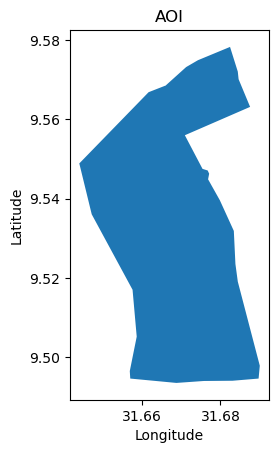

In [29]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
# Define render folder ---------
render_folder = Path('mnt/city-directories/03-render-output')
multi_scan_folder = Path('multi-scan-materials')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [30]:
#AOI AREA
def calculate_aoi_area(features):
    # Create a unit registry
    ureg = pint.UnitRegistry()

    # Combine geometries using unary_union from shapely
    combined_geometry = unary_union(features)

    # Calculate the area in square kilometers
    area_km2 = combined_geometry.area   # Convert square meters to square kilometers

    # Print the result using the pint library for unit formatting
    area_quantity = area_km2 *10000* ureg.km**2
    return area_quantity.to('km^2')

calculate_aoi_area(features)


23.146904876625676 <Unit('kilometer ** 2')>

In [31]:
#Climate
def get_koeppen_classification():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Calculate centroid of AOI
    centroid = features.centroid.values[0]

    # Retrieve centroid coordinates
    coords = {' Lon': centroid.x, 'Lat': centroid.y}

    # Read Köppen climate classification file
    koeppen_file_path = global_inputs.get('koeppen_source') #use an alternate dataset
    koeppen = pd.read_csv(koeppen_file_path)

    # Filter Köppen data for the region around the centroid with a buffer of 0.5 degrees
    lon_min, lon_max = coords[' Lon'] - 0.5, coords[' Lon'] + 0.5
    lat_min, lat_max = coords['Lat'] - 0.5, coords['Lat'] + 0.5
    koeppen_city = koeppen[
        (koeppen[' Lon'].between(lon_min, lon_max)) &
        (koeppen['Lat'].between(lat_min, lat_max))
    ][' Cls'].unique()

    # Print Köppen climate classification
    koeppen_text = ', '.join(koeppen_city)
    print(f"Köppen climate classification: {koeppen_text} (See https://en.wikipedia.org/wiki/Köppen_climate_classification for classes)")

    # Return Köppen climate classification if needed
    return koeppen_city


In [32]:
#Age Distribution by World Pop
def age_stats():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')

    if menu['demographics']:  
        age_file = os.path.join(output_folder, f"{city}_demographics.csv") 
        if os.path.exists(age_file):  
            pass
        else:
            print("Demographics file does not exist.")
            return  
    pop_dist_group_wp = pd.read_csv(age_file)

    
    pop_dist_group_wp = pop_dist_group_wp.rename(columns={"age_group": "Age_Bracket", "sex": "Sex"})
    pop_dist_group_wp['Count'] = pd.to_numeric(pop_dist_group_wp['population'], errors='coerce')
    pop_dist_group_wp['Age_Bracket'] = pop_dist_group_wp['Age_Bracket'].replace({'<1': '0-4', '1-4': '0-4'})
    pop_dist_group_wp = pop_dist_group_wp.groupby(['Age_Bracket', 'Sex']).agg(Count=('Count', 'sum')).reset_index()

    
    pop_dist_group_wp['Percentage'] = pop_dist_group_wp.groupby('Sex')['Count'].transform(lambda x: x / x.sum())
    pop_dist_group_wp['Sexed_Percent'] = pop_dist_group_wp.groupby('Sex')['Count'].transform(lambda x: x / x.sum())
    pop_dist_group_wp['Sexed_Percent_cum'] = pop_dist_group_wp.groupby('Sex')['Sexed_Percent'].cumsum()

    # Define custom colors for each sex
    colors = {'f': 'red', 'm': 'blue'}

    # Plot age-sex distribution with specified colors
    ax = sns.barplot(data=pop_dist_group_wp, x='Age_Bracket', y='Percentage', hue='Sex', dodge=True,
                    palette=colors)

    # Set plot title and labels
    plt.title(f"Population distribution in {city} by sex")
    plt.xlabel("Age Bracket")
    plt.ylabel("Percentage")

    # Customize legend manually
    legend_handles = []
    for sex, color in colors.items():
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label='Female' if sex == 'f' else 'Male'))

    # Display custom legend with specified labels and colors
    plt.legend(handles=legend_handles, title="Sex", loc="upper right")

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save and display the plot
    render_path = os.path.join(render_folder, f"{city}_age_stats.png")
    plt.savefig(render_path)
    plt.close()

    # Plotly
    pop_dist_group_wp_sorted = pop_dist_group_wp.sort_values(by='Age_Bracket')

    # Create the bar plot with the sorted DataFrame
    fig = px.bar(pop_dist_group_wp_sorted, x='Age_Bracket', y='Percentage', color='Sex', barmode='group', 
                title=f"Population distribution in {city} by sex", 
                labels={'Age_Bracket': 'Age Bracket', 'Percentage': 'Percentage', 'Sex': 'Sex'})

    # Update layout to set axis titles and legend title
    fig.update_layout(xaxis_title="Age Bracket", yaxis_title="Percentage", legend_title="Sex", plot_bgcolor='white')

    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=45)
    # Show the plot
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')
    under5 = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'] == '0-4']['Percentage'].sum()
    youth = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['15-19', '20-24'])]['Percentage'].sum()
    total_percent = pop_dist_group_wp['Percentage'].sum()
    working_age_rows = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64'])]
    working_age_percent = working_age_rows['Percentage'].sum()
    working_age = (working_age_percent / total_percent) 
    elderly = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['60-64', '65-69', '70-74', '75-79', '80+'])]['Percentage'].sum()
    total_count = pop_dist_group_wp['Count'].sum()
    female_count = pop_dist_group_wp[pop_dist_group_wp['Sex'] == 'f']['Count'].sum()
    female_pct = (female_count / total_count) * 100
    sex_ratio = (1 - female_pct) / female_pct * 100
    reproductive_age = pop_dist_group_wp[(pop_dist_group_wp['Sex'] == 'f') & (pop_dist_group_wp['Age_Bracket'].isin(['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49']))]['Sexed_Percent'].sum()

    
    print(f"under5: {under5:.2%}")
    print(f"youth (15-24): {youth:.2%}")
    print(f"working_age (15-64): {working_age:.2%}")
    print(f"elderly (60+): {elderly:.2%}")
    print(f"reproductive_age, percent of women (15-50): {reproductive_age:.2%}")
    print(f"sex_ratio: {round(sex_ratio, 2)} males to 100 females")



In [33]:

#Age structure Oxford Economics (If in Oxford)

'''
city='Mumbai'
def oxford_age_stats():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')
    
# Define the 'oxford_age_stats' function
def oxford_age_stats(city):
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')

    if 'oxford' in menu and menu['oxford']:  
        oxford_data_path = os.path.join(multi_scan_folder, "Oxford Global Cities Data.csv")
        if os.path.exists(oxford_data_path):  
            oxford_data = pd.read_csv(oxford_data_path)
            indicators = oxford_data['Indicator'].drop_duplicates()
            pop_dist_inds = [indicator for indicator in indicators if "Population" in indicator and indicator not in ["Population 0-14", "Population 15-64", "Population 65+"]]  

            if city in oxford_data['Location'].values:
                print(f"{city} exists in the Oxford file.")
                pop_dist_structure = oxford_data.loc[(oxford_data['Location'] == city) & (oxford_data['Indicator'].isin(pop_dist_inds))]
                print(pop_dist_structure.head(3))
                pop_dist_structure['Age_Bracket'] = pop_dist_structure['Indicator'].str[11:19]
                # Convert to numeric, handling errors by setting them to NaN
                pop_dist_structure['Age_Bracket'] = pd.to_numeric(pop_dist_structure['Age_Bracket'], errors='coerce')
                pop_dist_structure['Group'] = pd.cut(
                    pop_dist_structure['Age_Bracket'],
                    bins=[0, 4, 14, np.inf],  # Replace float('inf') with np.inf
                    labels=['Young', 'Working', '65+']
                )
                ''''''
                pop_dist_structure = pop_dist_structure.groupby(['Year', 'Group']).agg(Count=('Value', 'sum')).reset_index()
                pop_dist_structure['Percent'] = pop_dist_structure.groupby('Year')['Count'].transform(lambda x: x / x.sum())
                pop_dist_structure['pct_sum'] = pop_dist_structure.groupby('Year')['Percent'].cumsum()
                return pop_dist_structure
            else:
                print(f"{city} does not exist in the Oxford file.")
        else:
            print("Oxford file does not exist.")
    else:
        print("Oxford is not selected in the menu.")

# Example usage
oxford_age_stats('Mumbai')
'''


'\ncity=\'Mumbai\'\ndef oxford_age_stats():\n    with open("global_inputs.yml", \'r\') as f:\n        global_inputs = yaml.safe_load(f)\n\n    # Get city inputs\n    city_inputs = global_inputs.get(\'city_inputs\')\n    \n# Define the \'oxford_age_stats\' function\ndef oxford_age_stats(city):\n    with open("global_inputs.yml", \'r\') as f:\n        global_inputs = yaml.safe_load(f)\n\n    # Get city inputs\n    city_inputs = global_inputs.get(\'city_inputs\')\n\n    if \'oxford\' in menu and menu[\'oxford\']:  \n        oxford_data_path = os.path.join(multi_scan_folder, "Oxford Global Cities Data.csv")\n        if os.path.exists(oxford_data_path):  \n            oxford_data = pd.read_csv(oxford_data_path)\n            indicators = oxford_data[\'Indicator\'].drop_duplicates()\n            pop_dist_inds = [indicator for indicator in indicators if "Population" in indicator and indicator not in ["Population 0-14", "Population 15-64", "Population 65+"]]  \n\n            if city in oxford_d

In [34]:
# Share of GDP, Emp, Pop (If in Oxford)

In [35]:
# GDP, Pop, Emp Growth (If in Oxford)

In [36]:
# GDP per capita (If in Oxford)

In [37]:
# Share of employment by sector (If in Oxford)

In [38]:
#Economic Inequality (If in Oxford)

In [39]:
def wsf_stats():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')

    if menu['wsf']:  
        wsf_stats_file = Path(output_folder / f"{city}_wsf_stats.csv")  
        if os.path.exists(wsf_stats_file):  
            pass
        else:
            print("WSF stats file does not exist.")
            return  
        wsf = pd.read_csv(wsf_stats_file)
        
        wsf = wsf.rename(columns={'year': 'Year'}).\
        loc[:, ['Year', 'cumulative sq km']].\
        rename(columns={'cumulative sq km': 'uba_km2'})

        
        wsf['growth_pct'] = (wsf['uba_km2'] / wsf['uba_km2'].shift(1) - 1)
        wsf['growth_km2'] = wsf['uba_km2'] - wsf['uba_km2'].shift(1)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(wsf['Year'], wsf['uba_km2'], marker='o', linestyle='-')
        plt.title("Urban Built-up Area, 1985-2015")
        plt.xlabel("Year")
        plt.ylabel("Urban built-up area (sq. km)")
        plt.grid(True)
        # Save as PNG in output folder
        render_path = os.path.join(render_folder, f"{city}_urban_built_up_area.png")
        plt.savefig(render_path)
        plt.close()

        # Create Plotly
        fig = go.Figure()

        # Add trace for urban built-up area
        fig.add_trace(go.Scatter(
            x=wsf['Year'],
            y=wsf['uba_km2'],
            mode='lines+markers',
            name='Urban built-up area (km^2)'
        ))

        
        fig.update_layout(
            title="Urban Built-up Area, 1985-2015",
            xaxis_title="Year",
            yaxis_title="Urban built-up area (km^2)",
            template='plotly_white',
            showlegend=True,
            hovermode='x'
        )
        fig.show()
        fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')
        first_area = wsf['uba_km2'].iloc[0]
        latest_area = wsf['uba_km2'].iloc[-1]
        first_year = wsf['Year'].iloc[0]
        latest_year = wsf['Year'].iloc[-1]
        pct_growth = 100 * (latest_area - first_area) / first_area
        print(f"The city's built-up area grew from {round(first_area, 2)} sq. km in {first_year} to {round(latest_area, 2)} in {latest_year} for {round(pct_growth, 2)}% growth")


In [40]:
#Landcover Graph
def lc_stats():
    
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    
    city_inputs = global_inputs.get('city_inputs')

    if menu['landcover']:  
        lc_stats_file = Path(output_folder / f"{city}_lc.csv")  
        if not lc_stats_file.exists():  
            print("Land Cover stats file does not exist.")
            return  
        
        
        lc = pd.read_csv(lc_stats_file)

        # Define colors
        lc_colors = {
            "Tree cover": "#397e48",
            "Built-up": "#c4281b",
            "Grassland": "#88af52",
            "Bare / sparse vegetation": "#a59b8f",
            "Cropland": "#e49634",
            "Water bodies": "#429bdf",
            "Permanent water bodies": "#00008b",#change this
            "Mangroves": "#90EE90",#change this
            "Moss and lichen": "#013220",#change this
            "Shrubland": "#dfc25a",
            "Herbaceous wetland": "#7d87c4",
            "Snow and ice": "#F5F5F5"
        }
        #connect it to the frontend layers.yml

        
        total_pixels = lc['Pixel Count'].sum()

        
        lc['Percentage'] = lc['Pixel Count'] / total_pixels * 100

        
        # Matplotlib pie chart
        plt.figure(figsize=(8, 8))
        wedges, _, autotexts = plt.pie(lc['Pixel Count'], labels=None,
                                        colors=[lc_colors[lc_type] for lc_type in lc['Land Cover Type']],
                                        startangle=90, autopct='%1.0f%%')
        plt.title("Land Cover Distribution")
        
        # Add percentage labels to the pie chart for land cover types > 5%
        for autotext, pct in zip(autotexts, lc['Percentage']):
            if pct >= 5:
                autotext.set_color('black')
                autotext.set_size(10)
                autotext.set_text(f"{pct:.0f}%")
            else:
                autotext.set_text('')  # Hide labels for slices with percentage < 5%
        
        # Save matplotlib pie chart
        render_path = os.path.join(render_folder, f"{city}_landcover.png")
        plt.savefig(render_path)
        plt.close()
        
        
        fig = px.pie(lc, values='Pixel Count', names='Land Cover Type', color='Land Cover Type', color_discrete_map=lc_colors)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
        fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')

        # Dictionary to convert integers to ordinal strings
        ordinal_dict = {1: "first", 2: "second", 3: "third"}

        # Print the percentage of the first three highest values
        highest_values = lc.sort_values(by='Percentage', ascending=False).head(3)
        for i, (index, row) in enumerate(highest_values.iterrows()):
            ordinal_str = ordinal_dict.get(i + 1, str(i + 1) + "th")
            print(f"The {ordinal_str} highest landcover value is {row['Land Cover Type']} with {row['Percentage']:.2f}% of the total land area")
       
        
lc_stats()


The first highest landcover value is Grassland with 80.37% of the total land area
The second highest landcover value is Built-up with 8.41% of the total land area
The third highest landcover value is Shrubland with 6.54% of the total land area


In [43]:
#Elevation Graph
def elev_stats():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    city_inputs = global_inputs.get('city_inputs')
    if menu['elevation']:  
        elev_stats_file = Path(output_folder / f"{city}_elevation.csv") 
        if not elev_stats_file.exists():  
            print("Elevation stats file does not exist.")
            return  
        elev = pd.read_csv(elev_stats_file)
        # Calculate the total count
        total_count = elev['Count'].sum()

        # Calculate percentage
        elev['percent'] = elev['Count'] / total_count * 100

        # Convert to numeric
        elev['percent'] = pd.to_numeric(elev['percent'], errors='coerce')

        
        elevation = elev.dropna(subset=['Bin']).copy()  # Create a copy to avoid the warning

        # Preprocess the data
        elevation['Percent'] = (elevation['percent']/100).apply(lambda x: f"{x:.0%}") 
        elevation['Elevation'] = pd.to_numeric(elevation['Bin'].str.split('-').str[0], errors='coerce')  
        elevation = elevation.dropna(subset=['Elevation'])  
        elevation['Bin'] = pd.Categorical(elevation['Bin'], categories=elevation['Bin'].unique()) 
        print(elevation)
        # Define colors
        elevation_colors = {
            "0-2": "#f5c4c0",
            "2-5": "#f19bb4",
            "5-10": "#ec5fa1",
            "10-20": "#c20b8a",
            "20+": "#762175"
        }
        # Create the pie chart
        plt.figure(figsize=(8, 5))
        wedges, texts, autotexts = plt.pie(elevation['percent'], labels=None, colors=elevation_colors.values(), startangle=90, autopct='%1.0f%%')
        plt.title("Elevation Distribution")
        plt.legend(elevation['Elevation'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

        for autotext, pct in zip(autotexts, elevation['percent']):
            if pct < 3:
                autotext.set_text('')  # Hide labels for slices with percentage < 5%
            else:
                autotext.set_color('black')
                autotext.set_size(10)
                autotext.set_text(f"{pct:.0f}%")
        
        # Save the plot
        render_path = os.path.join(render_folder, f"{city}_elevation.png")
        plt.savefig(render_path, bbox_inches='tight')
        plt.close()

        # Create a pie chart with percentage labels
        fig = px.pie(elevation, values='percent', names='Elevation', hole=0.3,
                    color_discrete_sequence=list(elevation_colors.values()), 
                    title="Elevation Distribution", 
                    labels={'percent': 'Percentage', 'Elevation': 'Elevation Range'},
                    template='plotly_white')

        # Update layout
        fig.update_layout(legend=dict(orientation="h", x=0.5, y=1.1),
                        margin=dict(l=0, r=0, t=50, b=0))
        fig.show()
        fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')

        # Print the percentage of land 
        max_percent_index = elevation['percent'].idxmax()
        highest_percent_row = elevation.loc[max_percent_index]
        print(f"Highest percentage entry for Elevation is {highest_percent_row['Percent']} in the bin range {highest_percent_row['Bin']}")
elev_stats()





#why are they different?

       Bin  Count    percent Percent  Elevation
0  386-388     57   0.186579      0%        386
1  388-390    344   1.126023      1%        388
2  390-391  12970  42.454992     42%        390
3  391-393  17176  56.222586     56%        391
4  393-395      3   0.009820      0%        393


Highest percentage entry for Elevation is 56% in the bin range 391-393


In [19]:
#Slope Graph
def slope_stats():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    city_inputs = global_inputs.get('city_inputs')
    if menu['elevation']:  
        slope_stats_file = Path(output_folder / f"{city}_slope.csv") 
        if not slope_stats_file.exists():  
            print("Elevation stats file does not exist.")
            return  
        slope = pd.read_csv(slope_stats_file)
        
        # Calculate the total count
        total_count = slope['Count'].sum()

        # Calculate percentage
        slope['percent'] = slope['Count'] / total_count * 100

        # Convert to numeric
        slope['percent'] = pd.to_numeric(slope['percent'], errors='coerce')

        # Drop rows with NaN values in 'legend'
        slope = slope.dropna(subset=['Bin']).copy()

        # Preprocess the data
        slope['Percent'] = (slope['percent']/100).apply(lambda x: f"{x:.0%}")
        slope['Slope'] = slope['Bin'].str.extract(r"(\d+)").astype(float)
        slope['Bin'] = pd.Categorical(slope['Bin'], categories=slope['Bin'].unique())
        
        # Define colors
        slope_colors = {
            "0-2": "#ffffd4",
            "2-5": "#fed98e",
            "5-10": "#fe9929",
            "10-20": "#d95f0e",
            "20+": "#993404"
        }

        # Plot the donut chart
        plt.figure(figsize=(8, 5))
        plt.pie(slope['percent'], labels=None, colors=slope_colors.values(), startangle=90)
        wedges, texts, autotexts = plt.pie(slope['percent'], labels=None, colors=slope_colors.values(), startangle=90, autopct='%1.0f%%')

        plt.title("Slope Distribution")
        plt.legend(slope['Slope'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        # Add percentage labels
        for autotext, pct in zip(autotexts, slope['percent']):
            if pct < 3:
                autotext.set_text('')  # Hide labels for slices with percentage < 5%
            else:
                autotext.set_color('black')
                autotext.set_size(10)
                autotext.set_text(f"{pct:.0f}%")  # Display only percentage
        # Save the plot
        render_path = os.path.join(render_folder, f"{city}_slope.png")
        plt.savefig(render_path, bbox_inches='tight')
        plt.close()

        # Plotly
        fig = px.pie(slope, values='percent', names='Slope', hole=0.3,
                    color_discrete_sequence=list(slope_colors.values()), 
                    title="Slope Distribution", 
                    labels={'percent': 'Percentage', 'Slope': 'Slope Range'},
                    template='plotly_white')

        # Update layout
        fig.update_layout(legend=dict(orientation="h", x=0.5, y=1.1),
                        margin=dict(l=0, r=0, t=50, b=0))
        fig.show()
        fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')

        # Print the highest percentage value and consequent class
        max_percent_index = slope['percent'].idxmax()
        highest_percent_row = slope.loc[max_percent_index]
        print(f"Highest percentage entry for Slope is {highest_percent_row['Percent']} in the bin range {highest_percent_row['Bin']}")


Highest percentage entry for Slope is 100% in the bin range 0-2


In [25]:
#Cyclone Graph

In [26]:
#earthquake timeline


In [20]:


def flood_timeline():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    city_inputs = global_inputs.get('city_inputs')

    if menu['flood']:  
        flood_archive_path = global_inputs.get('flood_timeline_source')
        flood_archive = gpd.read_file(flood_archive_path)
        flood_archive = flood_archive[flood_archive.is_valid]
        aoi = features.to_crs(flood_archive.crs)
        flood_archive = flood_archive[flood_archive.intersects(aoi.unary_union)]
        fig, ax = plt.subplots()
        flood_archive.plot(column='DEAD', ax=ax, legend=True)

        floods = flood_archive[['BEGAN', 'ENDED', 'DEAD', 'DISPLACED', 'MAINCAUSE', 'SEVERITY']]

        # Tally of flood events
        print("Tally of flood events")
        print(floods.agg({'DEAD': 'sum', 'DISPLACED': 'sum', 'BEGAN': 'count'}))

        duration = (pd.to_datetime(floods['ENDED']) - pd.to_datetime(floods['BEGAN'])).dt.days

        # Prepare text for plotting
        flood_text = floods.copy()
        flood_text['severity'] = np.select([flood_text['SEVERITY'] == 1, flood_text['SEVERITY'] == 1.5, flood_text['SEVERITY'] == 2],
                                        ['Large event', 'Very large event', 'Extreme event'])
        flood_text['duration'] = duration
        flood_text['text'] = flood_text.apply(lambda row: f"{row['BEGAN']}, {row['severity'].lower()} {row['MAINCAUSE']}, "
                                                        f"{row['duration']} days, {row['DEAD']:,} fatalities, {row['DISPLACED']:,} displaced",
                                            axis=1)

        # Calculate coordinates for text plotting
        flood_text['node_x'] = pd.to_datetime(flood_text['BEGAN']) + pd.to_timedelta(1460 * (2 * (flood_text.index % 2) - 1), unit='D')
        flood_text['node_y'] = 0

        # Prepare lines for text plotting
        flood_lines = pd.concat([flood_text[['BEGAN', 'node_x', 'node_y']],
                                pd.DataFrame({'BEGAN': flood_text['BEGAN'], 'node_x': flood_text['BEGAN'], 'node_y': 0}),
                                pd.DataFrame({'BEGAN': flood_text['BEGAN'], 'node_x': flood_text['BEGAN'], 'node_y': 0})])

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 5.833))
        ax.plot(flood_lines['node_x'], flood_lines['node_y'], color='blue', linestyle='-')
        ax.scatter(flood_text['node_x'], flood_text['node_y'], color='red')
        for idx, row in flood_text.iterrows():
            ax.text(row['node_x'] + pd.to_timedelta(30, unit='D'), row['node_y'] - 50, row['text'], rotation=30, ha='center')
        ax.set_xlim(pd.Timestamp('1984-01-01'), pd.Timestamp('2020-12-31'))
        ax.set_ylim(-1800, 1800)
        ax.set_yticks([1825, 3650])
        ax.set_yticklabels([1825, 3650])
        plt.show()



#workshop this one 


In [21]:
def extract_monthly_stats():
    
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pv_directory = global_inputs.get('solar_graph_source')

    
    pv_files = [f for f in os.listdir(pv_directory) if f.endswith('.tif')]

    
    monthly_pv = []

    aoi = aoi_file.geometry

    for f in pv_files:
        pattern = re.compile(r'PVOUT_(\d{2})')
        match = pattern.search(f)
        if match:
            m = int(match.group(1))  # Extract the month

            file_path = os.path.join(pv_directory, f)

            with rasterio.open(file_path) as src:
                
                raster_data, raster_transform = mask(src, aoi.geometry, crop=True)

                stats = {
                    'month': m,
                    'max': np.nanmax(raster_data),
                    'min': np.nanmin(raster_data),
                    'mean': np.nanmean(raster_data),
                    'sum': np.nansum(raster_data)
                }

                
                monthly_pv.append(stats)
        else:
            print(f"No match found for filename: {f}")

    monthly_pv_df = pd.DataFrame(monthly_pv)

    # Sort by 'month'
    monthly_pv_df.sort_values(by='month', inplace=True)

    # Calculate daily PV energy yield
    monthly_pv_df['daily'] = monthly_pv_df['mean']/30

    
    highest_value = monthly_pv_df['daily'].max()
    lowest_value = monthly_pv_df['daily'].min()

    
    ratio = highest_value / lowest_value

    # Check if the ratio is greater than 2.5
    if ratio > 2.5:
        print("Seasonality is high, making solar energy available throughout the year")
    else:
        print("Seasonality is low to moderate, making solar energy available in only some of the months")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_pv_df['month'], monthly_pv_df['daily'], marker='o', linestyle='-')
    plt.text(1, 4.6, 'Excellent Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')
    plt.text(1, 3.6, 'Favorable Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')
    plt.xlabel('Month')
    plt.ylabel('Daily PV energy yield (kWh/kWp)')
    plt.title('Seasonal availability of solar energy')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.axhline(y=3.5, linestyle='--', color='black')
    plt.axhline(y=4.5, linestyle='--', color='black')
    plt.tight_layout()
    # Save the plot
    render_path = os.path.join(render_folder, f"{city}_PV_graph.png")
    plt.savefig(render_path, bbox_inches='tight')
    plt.close()
    #Plotly
    fig = px.line(monthly_pv_df, x='month', y='daily', markers=True)
    fig.add_annotation(x=1, y=4.6, text='Excellent Conditions', showarrow=False, font=dict(color='darkgrey'), xshift=5)
    fig.add_annotation(x=1, y=3.6, text='Favorable Conditions', showarrow=False, font=dict(color='darkgrey'), xshift=5)
    fig.update_xaxes(title='Month', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig.update_yaxes(title='Daily PV energy yield (kWh/kWp)', range=[0, 5])
    fig.add_shape(type="line", x0=1, y0=3.5, x1=12, y1=3.5, line=dict(color="black", width=1, dash='dash'))
    fig.add_shape(type="line", x0=1, y0=4.5, x1=12, y1=4.5, line=dict(color="black", width=1, dash='dash'))
    fig.update_layout(title='Seasonal availability of solar energy', xaxis=dict(showgrid=True, zeroline=False),plot_bgcolor='white')

    fig.show()
    fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')

